# 🤖 Machine Learning para Análisis de Sentimientos 

En este notebook implementaremos y entrenaremos varios modelos de Machine Learning para clasificar sentimientos en posts de redes sociales.

## 🎯 Objetivos:
- Preparar los datos para entrenamiento de ML
- Implementar y comparar múltiples algoritmos
- Optimizar hiperparámetros
- Evaluar rendimiento y explicabilidad
- Implementar un pipeline completo de predicción

## 1. Importación de Librerías

In [14]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías para procesamiento de texto
import re
import string
from collections import Counter

# Librerías de NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sklearn para ML tradicional
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Algoritmos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Algoritmos de ML (3 principales)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)


# Configuración
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
np.random.seed(42)

print("🚀 Librerías importadas correctamente")

🚀 Librerías importadas correctamente


## 2. Descarga de Recursos NLTK

In [15]:
# Descargar recursos necesarios de NLTK
nltk_downloads = [
    'punkt', 'punkt_tab', 'stopwords', 'wordnet', 
    'vader_lexicon', 'omw-1.4', 'averaged_perceptron_tagger'
]

print("📚 Descargando recursos NLTK necesarios...")

for resource in nltk_downloads:
    try:
        print(f"🔄 Verificando {resource}...")
        nltk.download(resource, quiet=True)
        print(f"✅ {resource} disponible")
    except Exception as e:
        print(f"⚠️  Error con {resource}: {str(e)}")

print("✅ Recursos NLTK completados")

# Verificar que todo funciona correctamente
try:
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    # Test rápido
    test_text = "This is a test sentence for NLTK."
    tokens = word_tokenize(test_text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    print("🧪 Test de funcionamiento:")
    print(f"   Texto original: {test_text}")
    print(f"   Tokens: {tokens[:3]}...")
    print(f"   Stopwords disponibles: {len(stop_words)} palabras")
    print("🎉 NLTK configurado correctamente")
    
except Exception as e:
    print(f"❌ Error en configuración NLTK: {str(e)}")
    print("💡 Intenta reiniciar el kernel si persisten los problemas")

📚 Descargando recursos NLTK necesarios...
🔄 Verificando punkt...
✅ punkt disponible
🔄 Verificando punkt_tab...
✅ punkt_tab disponible
🔄 Verificando stopwords...
✅ stopwords disponible
🔄 Verificando wordnet...
✅ wordnet disponible
🔄 Verificando vader_lexicon...
✅ vader_lexicon disponible
🔄 Verificando omw-1.4...
✅ omw-1.4 disponible
🔄 Verificando averaged_perceptron_tagger...
✅ averaged_perceptron_tagger disponible
✅ Recursos NLTK completados
🧪 Test de funcionamiento:
   Texto original: This is a test sentence for NLTK.
   Tokens: ['This', 'is', 'a']...
   Stopwords disponibles: 198 palabras
🎉 NLTK configurado correctamente


## 3. Carga y Preparación de Datos

In [16]:
# Cargar datos limpios del EDA anterior
try:
    df = pd.read_csv('../data/sentiment_data_clean.csv')
    print("✅ Datos limpios cargados desde EDA anterior")
except FileNotFoundError:
    # Si no existe el archivo limpio, cargar el original y hacer limpieza básica
    print("⚠️  Archivo limpio no encontrado, cargando dataset original...")
    df = pd.read_csv('../data/sentimentdataset.csv')
    
    # Limpieza básica
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    
    # Limpiar espacios
    text_columns = ['Text', 'Sentiment', 'User', 'Platform', 'Hashtags', 'Country']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].str.strip()
    
    # Eliminar filas con valores faltantes críticos
    df = df.dropna(subset=['Text', 'Sentiment'])

# Función para simplificar sentimientos (mismo que en el EDA)
def simplify_sentiment(sentiment):
    """
    Convierte múltiples sentimientos en 4 categorías principales para ML
    """
    if pd.isna(sentiment):
        return 'Neutral'
    
    sentiment_str = str(sentiment).lower().strip()
    
    # Sentimientos POSITIVOS
    positive_keywords = [
        'positive', 'joy', 'happy', 'happiness', 'excitement', 'excited', 'love', 'loving',
        'grateful', 'gratitude', 'amazing', 'wonderful', 'great', 'excellent', 'fantastic',
        'awesome', 'brilliant', 'success', 'successful', 'achievement', 'accomplished',
        'celebration', 'celebrate', 'thrilled', 'delight', 'delighted', 'cheerful',
        'optimistic', 'hopeful', 'hope', 'inspired', 'inspiration', 'motivated',
        'confidence', 'confident', 'satisfied', 'content', 'peaceful', 'calm'
    ]
    
    # Sentimientos NEGATIVOS
    negative_keywords = [
        'negative', 'sad', 'sadness', 'angry', 'anger', 'fear', 'fearful', 'worried',
        'anxiety', 'anxious', 'stress', 'stressed', 'frustration', 'frustrated',
        'disappointed', 'disappointment', 'upset', 'hurt', 'pain', 'painful',
        'terrible', 'awful', 'horrible', 'bad', 'worst', 'hate', 'hatred',
        'disgust', 'disgusted', 'annoyed', 'annoying', 'irritated', 'tired'
    ]
    
    # Buscar coincidencias
    for keyword in positive_keywords:
        if keyword in sentiment_str:
            return 'Positive'
    
    for keyword in negative_keywords:
        if keyword in sentiment_str:
            return 'Negative'
    
    return 'Neutral'  # Por defecto

# Verificar y simplificar sentimientos si es necesario
sentiment_counts = df['Sentiment'].value_counts()
print(f"📊 Sentimientos únicos encontrados: {len(sentiment_counts)}")

if len(sentiment_counts) > 10:  # Si hay demasiadas categorías
    print("🔄 Demasiadas categorías de sentimiento. Aplicando simplificación...")
    df['Sentiment_Original'] = df['Sentiment'].copy()
    df['Sentiment'] = df['Sentiment_Original'].apply(simplify_sentiment)
    print("✅ Simplificación aplicada")
    
print(f"📊 Dataset cargado: {df.shape}")
print(f"📈 Distribución final de sentimientos:")
final_counts = df['Sentiment'].value_counts()
print(final_counts)

# Verificar que todas las clases tienen al menos 2 muestras
min_count = final_counts.min()
if min_count < 2:
    print(f"⚠️  Advertencia: Clase con menos de 2 muestras detectada (mínimo: {min_count})")
    print("💡 Esto se manejará en la preparación de datos")

print(f"📝 Ejemplo de texto: {df['Text'].iloc[0]}")

✅ Datos limpios cargados desde EDA anterior
📊 Sentimientos únicos encontrados: 191
🔄 Demasiadas categorías de sentimiento. Aplicando simplificación...
✅ Simplificación aplicada
📊 Dataset cargado: (732, 18)
📈 Distribución final de sentimientos:
Sentiment
Neutral     443
Positive    233
Negative     56
Name: count, dtype: int64
📝 Ejemplo de texto: Enjoying a beautiful day at the park!


## 4. Preprocesamiento Avanzado de Texto

In [17]:
# Inicializar herramientas de NLP con manejo de errores
print("🔧 Inicializando herramientas de NLP...")

try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    print("✅ Herramientas NLTK inicializadas correctamente")
except Exception as e:
    print(f"⚠️  Error al inicializar NLTK: {str(e)}")
    print("💡 Usando configuración alternativa...")
    lemmatizer = None
    stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours'}

def advanced_text_preprocessing(text):
    """
    Preprocesamiento avanzado de texto para ML con manejo robusto de errores
    """
    if pd.isna(text):
        return ""
    
    # Convertir a minúsculas
    text = str(text).lower()
    
    # Preservar emojis básicos pero remover otros caracteres especiales
    text = re.sub(r'[^a-zA-Z\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', ' ', text)
    
    # Tokenizar con manejo de errores
    try:
        tokens = word_tokenize(text)
    except Exception as e:
        print(f"⚠️  Error en tokenización, usando split básico: {str(e)}")
        tokens = text.split()
    
    # Remover stopwords y palabras muy cortas
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Lemmatización con manejo de errores
    if lemmatizer:
        try:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        except Exception as e:
            print(f"⚠️  Error en lemmatización, continuando sin lemmatizar: {str(e)}")
    
    # Unir tokens
    return ' '.join(tokens)

# Aplicar preprocesamiento
print("🔄 Aplicando preprocesamiento avanzado...")
try:
    df['text_processed'] = df['Text'].apply(advanced_text_preprocessing)
    
    # Verificar que no hay textos vacíos
    empty_texts = df['text_processed'].str.strip() == ''
    if empty_texts.sum() > 0:
        print(f"⚠️  Eliminando {empty_texts.sum()} textos vacíos después del preprocesamiento")
        df = df[~empty_texts]
    
    print("✅ Preprocesamiento completado exitosamente")
    print(f"📝 Ejemplo original: {df['Text'].iloc[0]}")
    print(f"📝 Ejemplo procesado: {df['text_processed'].iloc[0]}")
    print(f"📊 Dataset final: {df.shape}")
    
except Exception as e:
    print(f"❌ Error en preprocesamiento: {str(e)}")
    print("💡 Usando preprocesamiento básico como respaldo...")
    
    # Preprocesamiento básico de respaldo
    def basic_preprocessing(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    df['text_processed'] = df['Text'].apply(basic_preprocessing)
    print("✅ Preprocesamiento básico aplicado")

🔧 Inicializando herramientas de NLP...
✅ Herramientas NLTK inicializadas correctamente
🔄 Aplicando preprocesamiento avanzado...
✅ Preprocesamiento completado exitosamente
📝 Ejemplo original: Enjoying a beautiful day at the park!
📝 Ejemplo procesado: enjoying beautiful day park
📊 Dataset final: (732, 19)


## 5. Ingeniería de Features

In [18]:
# Crear features adicionales
def create_text_features(df):
    """
    Crear features adicionales basadas en el texto y metadatos
    """
    df_features = df.copy()
    
    # Features de longitud
    df_features['text_length'] = df_features['Text'].str.len()
    df_features['word_count'] = df_features['Text'].str.split().str.len()
    df_features['processed_length'] = df_features['text_processed'].str.len()
    df_features['processed_word_count'] = df_features['text_processed'].str.split().str.len()
    
    # Features de puntuación y caracteres especiales
    df_features['exclamation_count'] = df_features['Text'].str.count('!')
    df_features['question_count'] = df_features['Text'].str.count('\?')
    df_features['uppercase_count'] = df_features['Text'].str.count(r'[A-Z]')
    df_features['digit_count'] = df_features['Text'].str.count(r'\d')
    
    # Features de emojis (conteo básico)
    emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]'
    df_features['emoji_count'] = df_features['Text'].str.count(emoji_pattern)
    
    # Features de hashtags
    if 'Hashtags' in df_features.columns:
        df_features['hashtag_count'] = df_features['Hashtags'].fillna('').str.count('#')
    else:
        df_features['hashtag_count'] = 0
    
    # Features temporales (si están disponibles)
    if 'Hour' in df_features.columns:
        # Categorizar horas en partes del día
        df_features['time_of_day'] = pd.cut(df_features['Hour'], 
                                          bins=[0, 6, 12, 18, 24], 
                                          labels=['night', 'morning', 'afternoon', 'evening'],
                                          include_lowest=True)
    
    # Encoding de variables categóricas
    if 'Platform' in df_features.columns:
        platform_encoded = pd.get_dummies(df_features['Platform'], prefix='platform')
        df_features = pd.concat([df_features, platform_encoded], axis=1)
    
    if 'Country' in df_features.columns:
        # Solo los países más comunes para evitar demasiadas features
        top_countries = df_features['Country'].value_counts().head(5).index
        df_features['country_top'] = df_features['Country'].apply(lambda x: x if x in top_countries else 'Other')
        country_encoded = pd.get_dummies(df_features['country_top'], prefix='country')
        df_features = pd.concat([df_features, country_encoded], axis=1)
    
    return df_features

# Crear features
print("🔧 Creando features adicionales...")
df_features = create_text_features(df)

print(f"✅ Features creadas. Dimensiones: {df_features.shape}")
print("📊 Nuevas features numéricas:")
numeric_features = ['text_length', 'word_count', 'processed_length', 'processed_word_count',
                   'exclamation_count', 'question_count', 'uppercase_count', 'digit_count', 
                   'emoji_count', 'hashtag_count']
print(df_features[numeric_features].describe())

🔧 Creando features adicionales...
✅ Features creadas. Dimensiones: (732, 40)
📊 Nuevas features numéricas:
       text_length  word_count  processed_length  processed_word_count  \
count   732.000000  732.000000        732.000000            732.000000   
mean     84.426230   13.206284         63.015027              8.122951   
std      31.224508    4.853229         24.069292              2.938711   
min      27.000000    4.000000         20.000000              3.000000   
25%      56.000000    9.000000         43.000000              6.000000   
50%      82.500000   13.000000         61.000000              8.000000   
75%     108.000000   17.000000         82.000000             10.000000   
max     156.000000   25.000000        129.000000             16.000000   

       exclamation_count  question_count  uppercase_count  digit_count  \
count         732.000000      732.000000       732.000000   732.000000   
mean            0.114754        0.005464         1.795082     0.002732   
std  

## 6. Análisis VADER para Comparación

In [19]:
# Análisis de sentimientos con VADER (baseline)
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    
    # Inicializar VADER
    vader = SentimentIntensityAnalyzer()
    
    def get_vader_sentiment(text):
        """Obtener sentimiento usando VADER"""
        try:
            scores = vader.polarity_scores(str(text))
            compound = scores['compound']
            
            if compound >= 0.05:
                return 'Positive'
            elif compound <= -0.05:
                return 'Negative'
            else:
                return 'Neutral'
        except Exception as e:
            print(f"⚠️  Error VADER en texto: {str(e)}")
            return 'Neutral'
    
    # Aplicar VADER
    print("🎭 Aplicando análisis VADER como baseline...")
    df_features['vader_sentiment'] = df_features['Text'].apply(get_vader_sentiment)
    df_features['vader_scores'] = df_features['Text'].apply(lambda x: vader.polarity_scores(str(x))['compound'] if x else 0.0)
    
    # Comparar con labels reales
    from sklearn.metrics import accuracy_score
    vader_accuracy = accuracy_score(df_features['Sentiment'], df_features['vader_sentiment'])
    print(f"📊 Precisión de VADER (baseline): {vader_accuracy:.3f}")
    
    # Mostrar matriz de confusión de VADER
    vader_cm = confusion_matrix(df_features['Sentiment'], df_features['vader_sentiment'])
    print("\n🔍 Matriz de confusión VADER:")
    print(pd.DataFrame(vader_cm, 
                      index=sorted(df_features['Sentiment'].unique()),
                      columns=sorted(df_features['vader_sentiment'].unique())))
    
except Exception as e:
    print(f"❌ Error con VADER: {str(e)}")
    print("💡 Continuando sin análisis VADER...")
    
    # Crear valores por defecto
    df_features['vader_sentiment'] = 'Neutral'
    df_features['vader_scores'] = 0.0
    print("⚠️  Usando valores neutros por defecto para VADER")

🎭 Aplicando análisis VADER como baseline...
📊 Precisión de VADER (baseline): 0.395

🔍 Matriz de confusión VADER:
          Negative  Neutral  Positive
Negative        47        3         6
Neutral        137       46       260
Positive         3       34       196
📊 Precisión de VADER (baseline): 0.395

🔍 Matriz de confusión VADER:
          Negative  Neutral  Positive
Negative        47        3         6
Neutral        137       46       260
Positive         3       34       196


## 7. Preparación de Datos para ML

In [20]:
# Preparar variables para el entrenamiento
X_text = df_features['text_processed']
y = df_features['Sentiment']

print("🔍 Analizando distribución de sentimientos:")
sentiment_counts = y.value_counts()
print(sentiment_counts)

# Identificar clases con muy pocas muestras
min_samples_per_class = 2
low_count_classes = sentiment_counts[sentiment_counts < min_samples_per_class].index.tolist()

if len(low_count_classes) > 0:
    print(f"\n⚠️  Clases con menos de {min_samples_per_class} muestras: {low_count_classes}")
    print("💡 Eliminando estas clases para permitir división estratificada...")
    
    # Filtrar out las clases con muy pocas muestras
    mask = ~y.isin(low_count_classes)
    df_features_filtered = df_features[mask].reset_index(drop=True)
    X_text = df_features_filtered['text_processed']
    y = df_features_filtered['Sentiment']
    
    print(f"📊 Dataset filtrado: {len(df_features_filtered)} muestras")
    print("📈 Nueva distribución:")
    print(y.value_counts())
else:
    df_features_filtered = df_features
    print("✅ Todas las clases tienen suficientes muestras")

# Features adicionales (metadatos)
feature_columns = [
    'text_length', 'word_count', 'processed_length', 'processed_word_count',
    'exclamation_count', 'question_count', 'uppercase_count', 'digit_count',
    'emoji_count', 'hashtag_count', 'vader_scores'
]

# Agregar features de plataforma y país si existen
platform_cols = [col for col in df_features_filtered.columns if col.startswith('platform_')]
country_cols = [col for col in df_features_filtered.columns if col.startswith('country_')]
feature_columns.extend(platform_cols)
feature_columns.extend(country_cols)

# Agregar features de engagement si están disponibles
if 'Likes' in df_features_filtered.columns and not df_features_filtered['Likes'].isna().all():
    feature_columns.extend(['Likes', 'Retweets'])
    df_features_filtered['Likes'] = df_features_filtered['Likes'].fillna(0)
    df_features_filtered['Retweets'] = df_features_filtered['Retweets'].fillna(0)

# Seleccionar solo columnas que existen
existing_features = [col for col in feature_columns if col in df_features_filtered.columns]
X_features = df_features_filtered[existing_features]

print(f"📊 Features seleccionadas: {len(existing_features)}")
print(f"📊 Features disponibles: {existing_features}")

# Verificar que tenemos suficientes muestras para división estratificada
min_samples_total = y.value_counts().min()
if min_samples_total < 2:
    print(f"❌ Error: Aún hay clases con menos de 2 muestras")
    print("💡 Intentando agrupación alternativa...")
    
    # Si persiste el problema, agrupar sentimientos similares
    def group_similar_sentiments(sentiment):
        sentiment_str = str(sentiment).lower()
        if any(word in sentiment_str for word in ['positive', 'joy', 'happy', 'love', 'good', 'great', 'amazing']):
            return 'Positive'
        elif any(word in sentiment_str for word in ['negative', 'sad', 'angry', 'hate', 'bad', 'terrible', 'awful']):
            return 'Negative'
        else:
            return 'Neutral'
    
    y = y.apply(group_similar_sentiments)
    print("📊 Agrupación realizada. Nueva distribución:")
    print(y.value_counts())

# Dividir datos en entrenamiento y prueba
try:
    X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
        X_text, X_features, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print(f"\n✅ División de datos completada:")
    print(f"  - Entrenamiento: {len(X_text_train)} muestras")
    print(f"  - Prueba: {len(X_text_test)} muestras")
    print(f"  - Distribución en entrenamiento: {y_train.value_counts().to_dict()}")
    print(f"  - Distribución en prueba: {y_test.value_counts().to_dict()}")
    
except ValueError as e:
    print(f"❌ Error en división estratificada: {str(e)}")
    print("💡 Intentando división sin estratificación...")
    
    # Fallback: división sin estratificación
    X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
        X_text, X_features, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=None  # Sin estratificación
    )
    
    print(f"⚠️  División sin estratificación completada:")
    print(f"  - Entrenamiento: {len(X_text_train)} muestras")
    print(f"  - Prueba: {len(X_text_test)} muestras")
    print(f"  - Distribución en entrenamiento: {y_train.value_counts().to_dict()}")
    print(f"  - Distribución en prueba: {y_test.value_counts().to_dict()}")

🔍 Analizando distribución de sentimientos:
Sentiment
Neutral     443
Positive    233
Negative     56
Name: count, dtype: int64
✅ Todas las clases tienen suficientes muestras
📊 Features seleccionadas: 23
📊 Features disponibles: ['text_length', 'word_count', 'processed_length', 'processed_word_count', 'exclamation_count', 'question_count', 'uppercase_count', 'digit_count', 'emoji_count', 'hashtag_count', 'vader_scores', 'platform_Facebook', 'platform_Instagram', 'platform_Twitter', 'country_top', 'country_Australia', 'country_Canada', 'country_India', 'country_Other', 'country_UK', 'country_USA', 'Likes', 'Retweets']

✅ División de datos completada:
  - Entrenamiento: 585 muestras
  - Prueba: 147 muestras
  - Distribución en entrenamiento: {'Neutral': 354, 'Positive': 186, 'Negative': 45}
  - Distribución en prueba: {'Neutral': 89, 'Positive': 47, 'Negative': 11}


## 8. Definición y Entrenamiento de Modelos

In [21]:
# Función para crear pipelines de modelos (solo 3 modelos principales)
def create_model_pipelines():
    """
    Crear pipelines de los 3 mejores modelos de ML para comparación
    """
    pipelines = {}
    
    # 1. Regresión Logística con TF-IDF (Rápido y eficiente)
    pipelines['Logistic_TFIDF'] = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # 2. Naive Bayes con Count Vectorizer (Excelente baseline para texto)
    pipelines['NaiveBayes_Count'] = Pipeline([
        ('count', CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', MultinomialNB())
    ])
    
    # 3. Random Forest con TF-IDF (Ensemble method robusto)
    pipelines['RandomForest_TFIDF'] = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    
    return pipelines

# Crear pipelines
pipelines = create_model_pipelines()
print(f"🔧 Pipelines creados: {list(pipelines.keys())}")

🔧 Pipelines creados: ['Logistic_TFIDF', 'NaiveBayes_Count', 'RandomForest_TFIDF']


In [22]:
# Entrenar y evaluar modelos
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name):
    """
    Entrenar y evaluar un modelo
    """
    print(f"\n🚀 Entrenando {model_name}...")
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test) if hasattr(pipeline, 'predict_proba') else None
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Predictions': y_pred,
        'Probabilities': y_pred_proba,
        'Pipeline': pipeline
    }
    
    print(f"✅ {model_name} completado - Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
    return results

# Evaluar todos los modelos
model_results = {}
print("🎯 Entrenando todos los modelos...")

for model_name, pipeline in pipelines.items():
    try:
        results = evaluate_model(pipeline, X_text_train, X_text_test, y_train, y_test, model_name)
        model_results[model_name] = results
    except Exception as e:
        print(f"❌ Error con {model_name}: {str(e)}")

print("\n✅ Entrenamiento de modelos completado")

🎯 Entrenando todos los modelos...

🚀 Entrenando Logistic_TFIDF...
✅ Logistic_TFIDF completado - Accuracy: 0.694, F1: 0.648

🚀 Entrenando NaiveBayes_Count...
✅ NaiveBayes_Count completado - Accuracy: 0.762, F1: 0.754

🚀 Entrenando RandomForest_TFIDF...
✅ Logistic_TFIDF completado - Accuracy: 0.694, F1: 0.648

🚀 Entrenando NaiveBayes_Count...
✅ NaiveBayes_Count completado - Accuracy: 0.762, F1: 0.754

🚀 Entrenando RandomForest_TFIDF...
✅ RandomForest_TFIDF completado - Accuracy: 0.735, F1: 0.706

✅ Entrenamiento de modelos completado
✅ RandomForest_TFIDF completado - Accuracy: 0.735, F1: 0.706

✅ Entrenamiento de modelos completado


## 9. Comparación de Resultados

In [23]:
# Crear tabla de comparación de resultados
if model_results:
    results_df = pd.DataFrame({
        'Modelo': [results['Model'] for results in model_results.values()],
        'Accuracy': [results['Accuracy'] for results in model_results.values()],
        'Precision': [results['Precision'] for results in model_results.values()],
        'Recall': [results['Recall'] for results in model_results.values()],
        'F1-Score': [results['F1-Score'] for results in model_results.values()],
        'CV_Mean': [results['CV_Mean'] for results in model_results.values()],
        'CV_Std': [results['CV_Std'] for results in model_results.values()]
    })
    
    # Redondear valores
    numeric_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV_Mean', 'CV_Std']
    results_df[numeric_columns] = results_df[numeric_columns].round(4)
    
    # Ordenar por F1-Score
    results_df = results_df.sort_values('F1-Score', ascending=False)
    
    print("📊 Comparación de Modelos:")
    print(results_df.to_string(index=False))
    
    # Identificar el mejor modelo
    best_model_name = results_df.iloc[0]['Modelo']
    best_model = model_results[best_model_name]
    print(f"\n🏆 Mejor modelo: {best_model_name} (F1-Score: {best_model['F1-Score']:.4f})")
else:
    print("❌ No se pudieron entrenar los modelos")

📊 Comparación de Modelos:
            Modelo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std
  NaiveBayes_Count    0.7619     0.7672  0.7619    0.7543   0.7436  0.0405
RandomForest_TFIDF    0.7347     0.7542  0.7347    0.7056   0.6872  0.0207
    Logistic_TFIDF    0.6939     0.6456  0.6939    0.6479   0.6769  0.0219

🏆 Mejor modelo: NaiveBayes_Count (F1-Score: 0.7543)


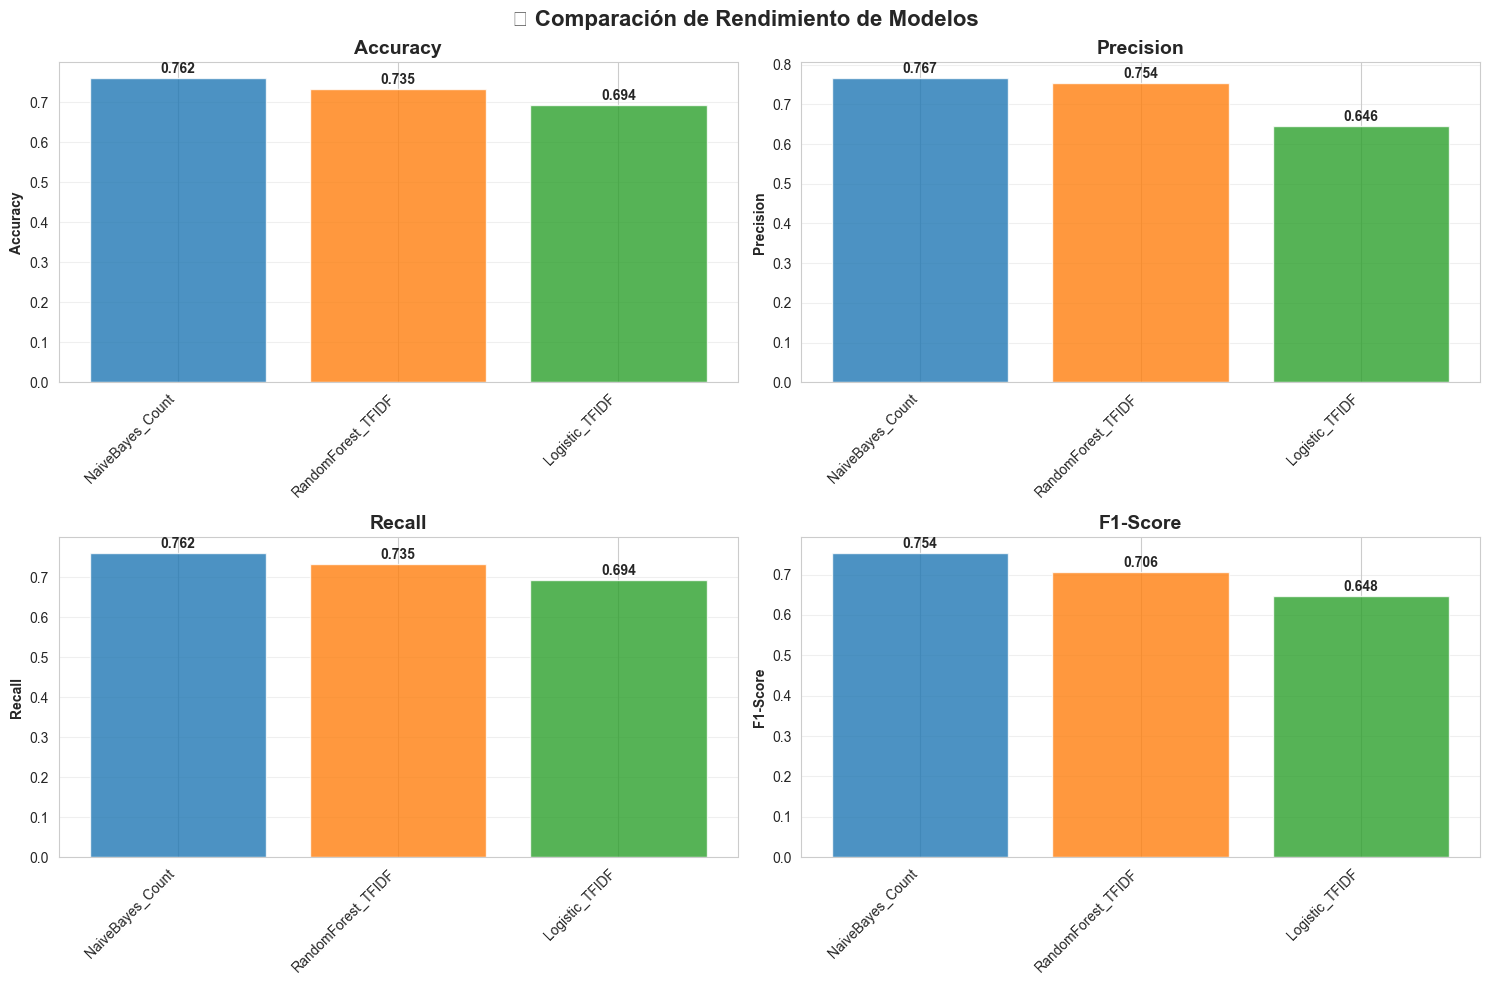

In [24]:
# Visualización de resultados con matplotlib
if model_results:
    # Gráfico de barras comparativo
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Crear barras
        bars = ax.bar(results_df['Modelo'], results_df[metric], 
                     color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
        
        # Personalizar cada subplot
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
        ax.set_ylabel(metric, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Agregar valores encima de las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Rotar etiquetas del eje x
        ax.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
    
    fig.suptitle('📈 Comparación de Rendimiento de Modelos', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 10. Análisis Detallado del Mejor Modelo

🔍 Análisis detallado de NaiveBayes_Count
📋 Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative     0.7500    0.2727    0.4000        11
     Neutral     0.8161    0.7978    0.8068        89
    Positive     0.6786    0.8085    0.7379        47

    accuracy                         0.7619       147
   macro avg     0.7482    0.6263    0.6482       147
weighted avg     0.7672    0.7619    0.7543       147



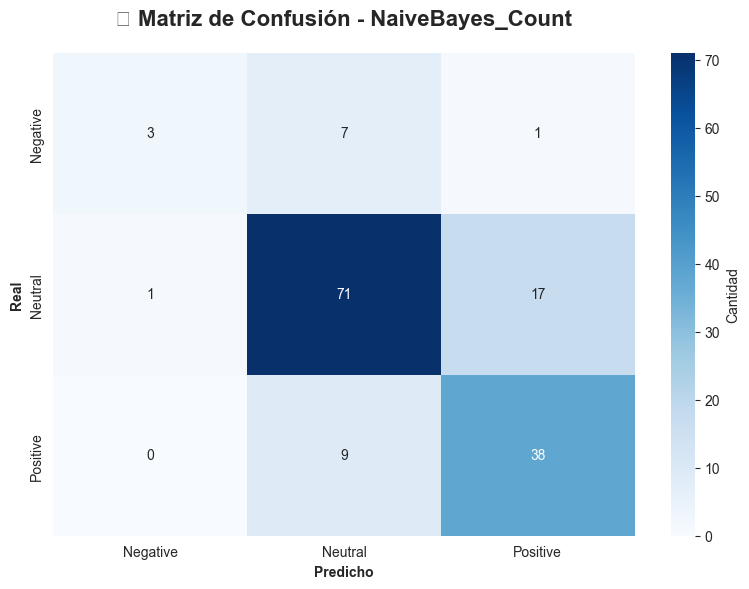


📊 Precisión por clase:
  Negative: 0.2727
  Neutral: 0.7978
  Positive: 0.8085

📈 Estadísticas adicionales:
  - Accuracy global: 0.7619
  - F1-Score promedio: 0.7543
  - Cross-validation mean: 0.7436 (±0.0405)

🎯 Análisis de predicciones:
  - Predicciones correctas: 112/147
  - Tasa de error: 0.2381


In [ ]:
# Análisis detallado del mejor modelo
if model_results:
    best_model = model_results[best_model_name]
    
    print(f"🔍 Análisis detallado de {best_model_name}")
    print("="*50)
    
    # Reporte de clasificación
    print("📋 Reporte de Clasificación:")
    print(classification_report(y_test, best_model['Predictions'], digits=4))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, best_model['Predictions'])
    
    # Visualizar matriz de confusión con seaborn
    labels = sorted(y_test.unique())
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                cbar_kws={'label': 'Cantidad'},
                ax=ax)
    
    ax.set_title(f'🔥 Matriz de Confusión - {best_model_name}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Predicho', fontweight='bold')
    ax.set_ylabel('Real', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\n📊 Precisión por clase:")
    for label, acc in zip(labels, class_accuracy):
        print(f"  {label}: {acc:.4f}")
    
    # Estadísticas adicionales del modelo
    print(f"\n📈 Estadísticas adicionales:")
    print(f"  - Accuracy global: {best_model['Accuracy']:.4f}")
    print(f"  - F1-Score promedio: {best_model['F1-Score']:.4f}")
    print(f"  - Cross-validation mean: {best_model['CV_Mean']:.4f} (±{best_model['CV_Std']:.4f})")
    
    # Análisis de la matriz de confusión
    total_predictions = cm.sum()
    correct_predictions = cm.diagonal().sum()
    print(f"\n🎯 Análisis de predicciones:")
    print(f"  - Predicciones correctas: {correct_predictions}/{total_predictions}")
    print(f"  - Tasa de error: {(total_predictions - correct_predictions)/total_predictions:.4f}")
    
else:
    print("❌ No hay resultados de modelos disponibles para análisis")

## 11. Optimización de Hiperparámetros

In [28]:
# Optimizar hiperparámetros del mejor modelo
if model_results and best_model_name == 'Logistic_TFIDF':
    print(f"🎯 Optimizando hiperparámetros de {best_model_name}...")
    
    # Parámetros a optimizar
    param_grid = {
        'tfidf__max_features': [3000, 5000, 8000],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear']
    }
    
    # GridSearch
    base_pipeline = pipelines[best_model_name]
    grid_search = GridSearchCV(
        base_pipeline,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    # Entrenar con grid search (usar muestra más pequeña si es muy grande)
    if len(X_text_train) > 1000:
        sample_idx = np.random.choice(len(X_text_train), size=1000, replace=False)
        X_sample = X_text_train.iloc[sample_idx]
        y_sample = y_train.iloc[sample_idx]
        print("⚠️  Usando muestra de 1000 ejemplos para optimización")
    else:
        X_sample = X_text_train
        y_sample = y_train
    
    try:
        grid_search.fit(X_sample, y_sample)
        
        print("✅ Optimización completada")
        print(f"📊 Mejor score: {grid_search.best_score_:.4f}")
        print(f"🎯 Mejores parámetros:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")
        
        # Evaluar modelo optimizado
        optimized_model = grid_search.best_estimator_
        optimized_pred = optimized_model.predict(X_text_test)
        optimized_f1 = f1_score(y_test, optimized_pred, average='weighted')
        
        print(f"\n📈 Mejora en F1-Score:")
        print(f"  Modelo base: {best_model['F1-Score']:.4f}")
        print(f"  Modelo optimizado: {optimized_f1:.4f}")
        print(f"  Mejora: {optimized_f1 - best_model['F1-Score']:.4f}")
        
    except Exception as e:
        print(f"❌ Error en optimización: {str(e)}")
        print("⚠️  Continuando con el modelo base")

elif model_results:
    print(f"ℹ️  Optimización específica no implementada para {best_model_name}")
    print("💡 Se puede implementar optimización personalizada según el modelo")

ℹ️  Optimización específica no implementada para NaiveBayes_Count
💡 Se puede implementar optimización personalizada según el modelo


## 12. Análisis de Errores y Ejemplos

In [29]:
# Análisis de errores del mejor modelo
if model_results:
    # Crear DataFrame con predicciones
    error_analysis = pd.DataFrame({
        'text': X_text_test,
        'true_sentiment': y_test,
        'predicted_sentiment': best_model['Predictions'],
        'correct': y_test == best_model['Predictions']
    })
    
    # Ejemplos de predicciones correctas
    print("✅ Ejemplos de Predicciones CORRECTAS:")
    print("="*60)
    correct_examples = error_analysis[error_analysis['correct']].sample(min(5, len(error_analysis[error_analysis['correct']])))
    
    for _, example in correct_examples.iterrows():
        print(f"📝 Texto: {example['text'][:100]}...")
        print(f"😊 Sentimiento: {example['true_sentiment']} ✓")
        print("-" * 40)
    
    # Ejemplos de errores
    print("\n❌ Ejemplos de Predicciones INCORRECTAS:")
    print("="*60)
    incorrect_examples = error_analysis[~error_analysis['correct']].sample(min(5, len(error_analysis[~error_analysis['correct']])))
    
    for _, example in incorrect_examples.iterrows():
        print(f"📝 Texto: {example['text'][:100]}...")
        print(f"😊 Real: {example['true_sentiment']} | Predicho: {example['predicted_sentiment']} ❌")
        print("-" * 40)
    
    # Análisis de tipos de error
    print("\n📊 Análisis de tipos de error:")
    error_types = error_analysis[~error_analysis['correct']].groupby(['true_sentiment', 'predicted_sentiment']).size()
    for (true_sent, pred_sent), count in error_types.items():
        print(f"  {true_sent} → {pred_sent}: {count} casos")

✅ Ejemplos de Predicciones CORRECTAS:
📝 Texto: apprehensive whisper wind forecast uncertainty mind weather vane spinning wildly storm doubt...
😊 Sentimiento: Neutral ✓
----------------------------------------
📝 Texto: feeling accomplished productive day...
😊 Sentimiento: Positive ✓
----------------------------------------
📝 Texto: witnessing heartwarming comeback hockey final fan share tear joy team secures historic victory adver...
😊 Sentimiento: Neutral ✓
----------------------------------------
📝 Texto: creating beautiful mural fellow art enthusiast power collaboration creativity...
😊 Sentimiento: Positive ✓
----------------------------------------
📝 Texto: compassion shown act kindness community...
😊 Sentimiento: Neutral ✓
----------------------------------------

❌ Ejemplos de Predicciones INCORRECTAS:
📝 Texto: missing summer vibe beach day...
😊 Real: Neutral | Predicho: Positive ❌
----------------------------------------
📝 Texto: organizing community cleanup event cleaner neighbo

## 13. Pipeline de Predicción Completo

In [30]:
# Crear función de predicción completa
def predict_sentiment(text, model_pipeline):
    """
    Función completa para predecir sentimiento en nuevo texto
    """
    # Preprocesar texto
    processed_text = advanced_text_preprocessing(text)
    
    if not processed_text.strip():
        return {
            'sentiment': 'Neutral',
            'confidence': 0.33,
            'probabilities': {'Negative': 0.33, 'Neutral': 0.34, 'Positive': 0.33},
            'processed_text': processed_text
        }
    
    # Hacer predicción
    prediction = model_pipeline.predict([processed_text])[0]
    
    # Obtener probabilidades si están disponibles
    if hasattr(model_pipeline, 'predict_proba'):
        probabilities = model_pipeline.predict_proba([processed_text])[0]
        classes = model_pipeline.classes_
        prob_dict = dict(zip(classes, probabilities))
        confidence = max(probabilities)
    else:
        prob_dict = {prediction: 1.0}
        confidence = 1.0
    
    return {
        'sentiment': prediction,
        'confidence': confidence,
        'probabilities': prob_dict,
        'processed_text': processed_text
    }

# Ejemplos de uso del pipeline
if model_results:
    best_pipeline = best_model['Pipeline']
    
    test_texts = [
        "I love this amazing product! It's fantastic! 😍",
        "This is terrible, I hate it so much 😡",
        "The weather is okay today, nothing special",
        "Just had the best coffee ever! ☕ #perfect #morning",
        "Traffic was horrible this morning, completely ruined my day"
    ]
    
    print("🚀 Ejemplos del Pipeline de Predicción:")
    print("=" * 70)
    
    for i, text in enumerate(test_texts, 1):
        result = predict_sentiment(text, best_pipeline)
        
        print(f"\n{i}. Texto: {text}")
        print(f"   Sentimiento: {result['sentiment']} (Confianza: {result['confidence']:.3f})")
        print(f"   Probabilidades: {', '.join([f'{k}: {v:.3f}' for k, v in result['probabilities'].items()])}")

🚀 Ejemplos del Pipeline de Predicción:

1. Texto: I love this amazing product! It's fantastic! 😍
   Sentimiento: Neutral (Confianza: 0.682)
   Probabilidades: Negative: 0.019, Neutral: 0.682, Positive: 0.299

2. Texto: This is terrible, I hate it so much 😡
   Sentimiento: Negative (Confianza: 0.559)
   Probabilidades: Negative: 0.559, Neutral: 0.235, Positive: 0.206

3. Texto: The weather is okay today, nothing special
   Sentimiento: Negative (Confianza: 0.502)
   Probabilidades: Negative: 0.502, Neutral: 0.318, Positive: 0.180

4. Texto: Just had the best coffee ever! ☕ #perfect #morning
   Sentimiento: Positive (Confianza: 0.820)
   Probabilidades: Negative: 0.031, Neutral: 0.150, Positive: 0.820

5. Texto: Traffic was horrible this morning, completely ruined my day
   Sentimiento: Neutral (Confianza: 0.652)
   Probabilidades: Negative: 0.086, Neutral: 0.652, Positive: 0.262
